# Generalized Polarizabilties - comparison with multipole expansion


**New functionalities in `multipole` added in v1.1.3**

<span style="color: red;">**!!CAUTION!!**</span>  **: `multipole` is a new functionality. Please report possible problems and errors.**

Here we demonstrate the generalized polarizabilities (GP), and compare them to the exact multipole decomposition of the internal fields following reference [1]. The GP formalism is described in [2].

[1] Alaee, R., Rockstuhl, C. and Fernandez-Corbaton, I. *An electromagnetic multipole expansion beyond the long-wavelength approximation*. **Optics Communications** 407, 17-21 (2018)

[2] Majorel et al. *Generalized polarizabilites for an exact multipole analysis of complex nanostructures under inhomogeneous illumination*. **arXiv** (2022)



## Simulation setup

structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 512/512 dipoles valid


/home/pwiecha/.local/lib/python3.8/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")


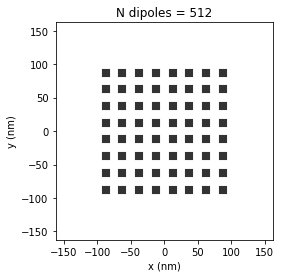

In [1]:
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt
import copy

from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import tools
from pyGDM2 import propagators
from pyGDM2 import linear
from pyGDM2 import core
from pyGDM2 import visu
from pyGDM2 import multipole


# =============================================================================
# sim setup
# =============================================================================
method = 'lu'
# method = 'cupy'


## ----- set up single structure
step = 25
mat = materials.dummy(4)

geo = structures.rect_wire(step, L=8, W=8, H=8, mesh='cube')
struct = structures.struct(step, geo, mat)
struct = structures.center_struct(struct, which_axis=['x','y','z'])


## ----- illumination
wavelengths = np.linspace(500, 1200, 36)
field_generator = fields.plane_wave
field_kwargs = dict(E_s=0, E_p=1, inc_angle=0, inc_plane='xz') # lin-pol X, normal incidence from below

efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=copy.deepcopy(field_kwargs))

## ----- environment: vacuum
n1 = 1.0
dyads = propagators.DyadsQuasistatic123(n1)


## ----- simulation1
sim = core.simulation(struct=struct, efield=efield, dyads=dyads)
visu.structure(sim, tit='N dipoles = {}'.format(len(sim.struct.geometry)))


## Run scattering simulation

In [2]:
## for comparison
sim.scatter(method=method)

timing for wl=500.00nm - setup: EE 1288.9ms, inv.: 704.1ms, repropa.: 353.3ms (1 field configs), tot: 2414.9ms
timing for wl=520.00nm - setup: EE 14.5ms, inv.: 55.4ms, repropa.: 11.5ms (1 field configs), tot: 81.5ms
timing for wl=540.00nm - setup: EE 14.8ms, inv.: 54.0ms, repropa.: 11.5ms (1 field configs), tot: 80.4ms
timing for wl=560.00nm - setup: EE 11.1ms, inv.: 53.9ms, repropa.: 11.5ms (1 field configs), tot: 76.7ms
timing for wl=580.00nm - setup: EE 15.7ms, inv.: 55.0ms, repropa.: 11.7ms (1 field configs), tot: 82.5ms
timing for wl=600.00nm - setup: EE 14.6ms, inv.: 53.5ms, repropa.: 12.4ms (1 field configs), tot: 80.6ms
timing for wl=620.00nm - setup: EE 13.8ms, inv.: 53.7ms, repropa.: 11.7ms (1 field configs), tot: 79.3ms
timing for wl=640.00nm - setup: EE 10.5ms, inv.: 54.2ms, repropa.: 11.6ms (1 field configs), tot: 76.5ms
timing for wl=660.00nm - setup: EE 10.6ms, inv.: 54.2ms, repropa.: 11.5ms (1 field configs), tot: 76.5ms
timing for wl=680.00nm - setup: EE 11.1ms, inv.: 

1

## Multipole expansion of internal fields

In [3]:
# =============================================================================
# --- full sim multipole expansion
# =============================================================================
p_sim = []
pt_sim = []
m_sim = []
qm_sim = []
qe_sim = []
qet_sim = []
for i, wl in enumerate(wavelengths):
    all_configs = tools.get_possible_field_params_spectra(sim)
    
    p_sim.append([])
    pt_sim.append([])
    m_sim.append([])
    qm_sim.append([])
    qe_sim.append([])
    qet_sim.append([])
    for kws in all_configs:
        kws_wl = copy.deepcopy(kws)
        kws_wl['wavelength'] = wl
        field_index = tools.get_closest_field_index(sim, kws_wl)
        
        ## P, M from full sim
        p,pt,m,qm,qe1,qet = multipole.multipole_decomposition_exact(
                    sim, field_index, 
                    which_moments=['p1', 'pt', 'm', 'qm', 'qe1', 'qet'])
    
        p_sim[-1].append(p)
        pt_sim[-1].append(pt)
        m_sim[-1].append(m)
        qm_sim[-1].append(qm)
        qe_sim[-1].append(qe1)
        qet_sim[-1].append(qet)

p_sim = np.array(p_sim)
pt_sim = np.array(pt_sim)
m_sim = np.array(m_sim)
qm_sim = np.array(qm_sim)
qe_sim = np.array(qe_sim)
qet_sim = np.array(qet_sim)

## "exact" generalized polarizabilities

In [4]:
# =============================================================================
# --- "exact" generalized polarizabilities
# =============================================================================
p_gp_ex = []
pt_gp_ex = []
m_gp_ex = []
qm_gp_ex = []
qe_gp_ex = []
qet_gp_ex = []
for i, wl in enumerate(wavelengths):
    K_P_E, K_T_E, K_QE_E, K_QT_E, K_M_E, K_QM_E = multipole.generalized_polarizability(sim, i, method=method)

    all_configs = tools.get_possible_field_params_spectra(sim)
    
    p_gp_ex.append([])
    pt_gp_ex.append([])
    m_gp_ex.append([])
    qm_gp_ex.append([])
    qe_gp_ex.append([])
    qet_gp_ex.append([])
    for kws in all_configs:
        kws_wl = copy.deepcopy(kws)
        kws_wl['wavelength'] = wl
        field_index = tools.get_closest_field_index(sim, kws_wl)
        
        p2_0 = multipole.eval_generalized_polarizability_p(sim, field_index, which_order='p1')
        m2 = multipole.eval_generalized_polarizability_m(sim, field_index)
        p2t = multipole.eval_generalized_polarizability_p(sim, field_index, which_order='pt')
        mq2 = multipole.eval_generalized_polarizability_qm(sim, field_index)
        qe2_0 = multipole.eval_generalized_polarizability_qe(sim, field_index, which_order='qe1')
        qe2t = multipole.eval_generalized_polarizability_qe(sim, field_index, which_order='qet')
    
        p_gp_ex[-1].append(p2_0)
        m_gp_ex[-1].append(m2)
        pt_gp_ex[-1].append(p2t)
        qm_gp_ex[-1].append(mq2)
        qe_gp_ex[-1].append(qe2_0)
        qet_gp_ex[-1].append(qe2t)
        
p_gp_ex = np.array(p_gp_ex)
pt_gp_ex = np.array(pt_gp_ex)
m_gp_ex = np.array(m_gp_ex)
qm_gp_ex = np.array(qm_gp_ex)
qe_gp_ex = np.array(qe_gp_ex)
qet_gp_ex = np.array(qet_gp_ex)

wl=500.0nm. calc. K: 85.2ms.  electric... 975.1ms.  magnetic... 199.7ms. Done.
wl=520.0nm. calc. K: 78.5ms.  electric... 980.2ms.  magnetic... 200.9ms. Done.
wl=540.0nm. calc. K: 80.9ms.  electric... 997.9ms.  magnetic... 201.1ms. Done.
wl=560.0nm. calc. K: 76.8ms.  electric... 985.0ms.  magnetic... 202.0ms. Done.
wl=580.0nm. calc. K: 73.0ms.  electric... 998.4ms.  magnetic... 202.9ms. Done.
wl=600.0nm. calc. K: 74.2ms.  electric... 957.1ms.  magnetic... 198.3ms. Done.
wl=620.0nm. calc. K: 77.5ms.  electric... 969.9ms.  magnetic... 197.6ms. Done.
wl=640.0nm. calc. K: 71.6ms.  electric... 979.9ms.  magnetic... 201.0ms. Done.
wl=660.0nm. calc. K: 75.5ms.  electric... 984.2ms.  magnetic... 199.3ms. Done.
wl=680.0nm. calc. K: 76.0ms.  electric... 977.3ms.  magnetic... 198.3ms. Done.
wl=700.0nm. calc. K: 77.8ms.  electric... 979.2ms.  magnetic... 198.8ms. Done.
wl=720.0nm. calc. K: 76.8ms.  electric... 965.2ms.  magnetic... 198.2ms. Done.
wl=740.0nm. calc. K: 74.6ms.  electric... 973.4ms.  

## plot spectra

Note that the generalized polarizabilities and the conventional multipole expansion lines are exactly superposed and hence only a single line is visible.

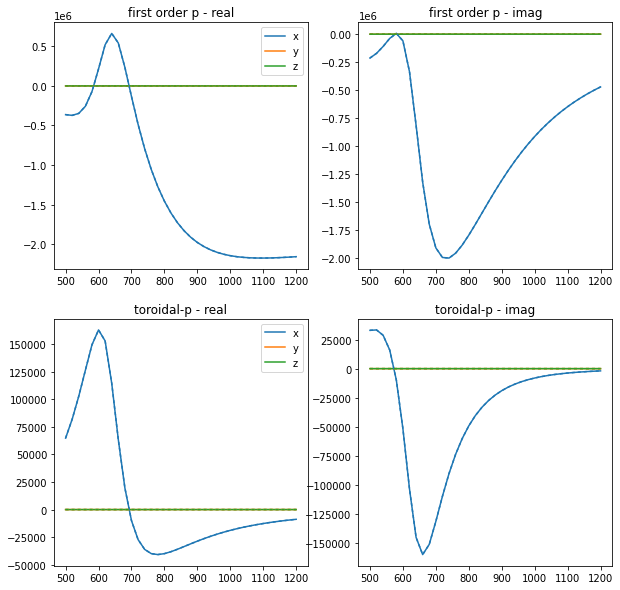

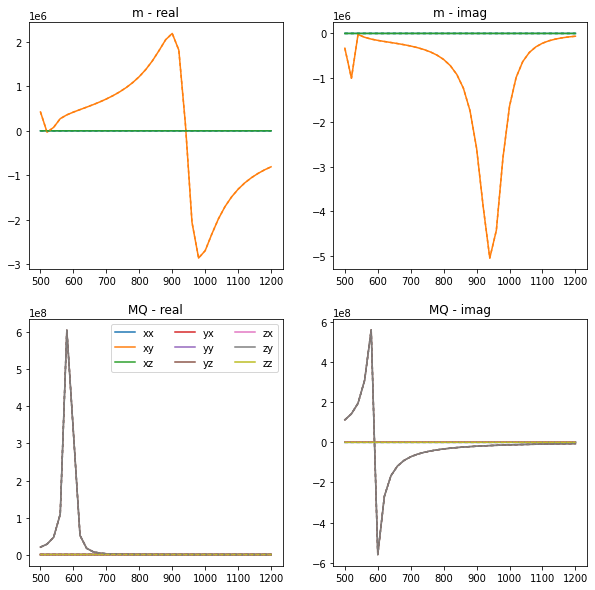

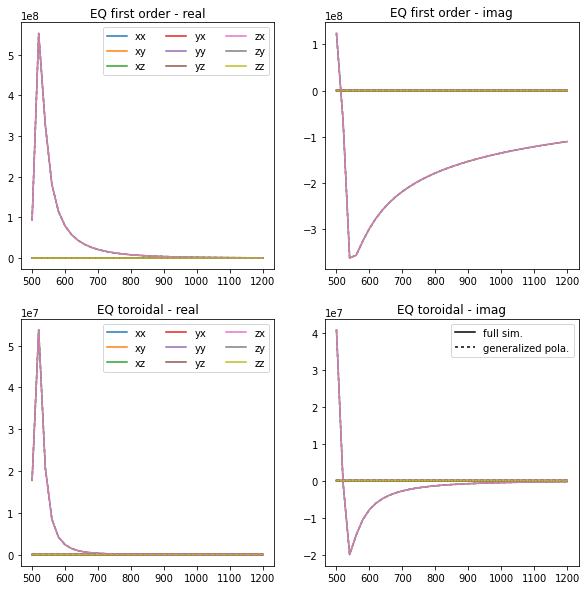

In [5]:
# =============================================================================
# plot electric dipole terms
# =============================================================================
wls = wavelengths


plt.figure(figsize=(10,10))

plt.subplot(221); plt.title('first order p - real')
plt.plot(wls, p_sim[:,0].real, label=['x','y','z'])
plt.gca().set_prop_cycle(None)
plt.plot(wls, p_gp_ex[:,0].real, label='', dashes=[2,2])
plt.legend()

plt.subplot(222); plt.title('first order p - imag')
plt.plot(wls, p_sim[:,0].imag, label='', )
plt.gca().set_prop_cycle(None)
plt.plot(wls, p_gp_ex[:,0].imag, label='', dashes=[2,2])

plt.subplot(223); plt.title('toroidal-p - real')
plt.plot(wls, pt_sim[:,0].real, label=['x','y','z'])
plt.gca().set_prop_cycle(None)
plt.plot(wls, pt_gp_ex[:,0].real, label='', dashes=[2,2])
plt.legend()

plt.subplot(224); plt.title('toroidal-p - imag')
plt.plot(wls, pt_sim[:,0].imag, label='', )
plt.gca().set_prop_cycle(None)
plt.plot(wls, pt_gp_ex[:,0].imag, label='', dashes=[2,2])

plt.show()



# =============================================================================
# plot magnetic dipole and quadrupole
# =============================================================================
plt.figure(figsize=(10,10))

plt.subplot(221); plt.title('m - real')
plt.plot(wls, m_sim[:,0].real, label='')
plt.gca().set_prop_cycle(None)
plt.plot(wls, m_gp_ex[:,0].real, label='', dashes=[2,2])

plt.subplot(222); plt.title('m - imag')
plt.plot(wls, m_sim[:,0].imag, label='')
plt.gca().set_prop_cycle(None)
plt.plot(wls, m_gp_ex[:,0].imag, label='', dashes=[2,2])

quadlabels = []
for i1 in ['x','y','z']: 
    for i2 in ['x','y','z']: 
        quadlabels.append(i1+i2)
plt.subplot(223); plt.title('MQ - real')
plt.plot(wls, qm_sim[:,0].reshape([-1,9]).real, label=quadlabels)
plt.gca().set_prop_cycle(None)
plt.plot(wls, qm_gp_ex[:,0].reshape([-1,9]).real, label='', dashes=[2,2])
plt.legend(ncol=3)

plt.subplot(224); plt.title('MQ - imag')
plt.plot(wls, qm_sim[:,0].reshape([-1,9]).imag, label='')
plt.gca().set_prop_cycle(None)
plt.plot(wls, qm_gp_ex[:,0].reshape([-1,9]).imag, label='', dashes=[2,2])

plt.show()



# =============================================================================
# plot electric quadrupole terms
# =============================================================================
plt.figure(figsize=(10,10))

quadlabels = []
for i1 in ['x','y','z']: 
    for i2 in ['x','y','z']: 
        quadlabels.append(i1+i2)
plt.subplot(221); plt.title('EQ first order - real')
plt.plot(wls, qe_sim[:,0].reshape([-1,9]).real, label=quadlabels)
plt.gca().set_prop_cycle(None)
plt.plot(wls, qe_gp_ex[:,0].reshape([-1,9]).real, label='', dashes=[2,2])
plt.legend(ncol=3)

plt.subplot(222); plt.title('EQ first order - imag')
plt.plot(wls, qe_sim[:,0].reshape([-1,9]).imag, label='')
plt.gca().set_prop_cycle(None)
plt.plot(wls, qe_gp_ex[:,0].reshape([-1,9]).imag, label='', dashes=[2,2])

plt.subplot(223); plt.title('EQ toroidal - real')
plt.plot(wls, qet_sim[:,0].reshape([-1,9]).real, label=quadlabels)
plt.gca().set_prop_cycle(None)
plt.plot(wls, qet_gp_ex[:,0].reshape([-1,9]).real, label='', dashes=[2,2])
plt.legend(ncol=3)

plt.subplot(224); plt.title('EQ toroidal - imag')
plt.plot(wls, qet_sim[:,0].reshape([-1,9]).imag, label='')
plt.gca().set_prop_cycle(None)
plt.plot(wls, qet_gp_ex[:,0].reshape([-1,9]).imag, label='', dashes=[2,2])
plt.plot([],[], color='k', label='full sim.')
plt.plot([],[], dashes=[2,2], color='k', label='generalized pola.')
plt.legend()

plt.show()